In [207]:
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

In [208]:
# Указываем параметры
Z = 3  # Выбираем гипергеометричское распределение
P = 3  # Число признаков
N = 5  # Число классов

M = 100  # Число наблюдений

In [209]:
data = []
for i in range(N):
    ngood = np.random.randint(70, 100)
    nbad = 100 - ngood
    nsample = np.random.randint(1, 100)

    c = np.random.hypergeometric(ngood=ngood, nbad=nbad, nsample=nsample, size=(M, P))
    # ngood - количество "хороших" элементов в выборке
    # nbad - количество "плохих" элементов в выборке
    # nsample - общий размер выборки
    # size - форма матрицы данных, которую

    data.append(c)

In [210]:
# Собираем признаки из всех классов
xs = np.concatenate([c[:, 0] for c in data]) # Признаки по оси X
ys = np.concatenate([c[:, 1] for c in data])  # Признаки по оси Y
zs = np.concatenate([c[:, 2] for c in data]) # Признаки по оси Z

xsyszs = [[xs[i], ys[i], zs[i]] for i in range(len(xs))]  # Собираем тройки признаков

In [211]:
# Создаем список Y, присваивая каждому классу уникальное значение
# Y будет представлять классификационный признак,
# который указывает на принадлежность каждой точки данных к одному из 5 классов.
Y = []
for i in range(N):
    Y.extend([i] * M)

# Преобразуем список Y в массив numpy
Y = np.array(Y)

In [212]:
# Создаем DataFrame `res_df` из списка `xsyszs`, где `xsyszs` содержит тройки признаков (x, y, z) для каждой точки данных.
res_df = pd.DataFrame(xsyszs)

# Создаем трехмерный рассеянный график с использованием библиотеки Plotly Express.
# Аргументы `x=0`, `y=1`, `z=2` указывают столбцы DataFrame для координат осей X, Y и Z соответственно.
# Аргумент `color=Y` определяет цвет точек на графике в соответствии с классификационным признаком из массива `Y`.
fig = px.scatter_3d(res_df, x=0, y=1, z=2, color=Y)

# Отображаем созданный трехмерный график.
fig.show()


In [213]:
# Стандартизируем данные
sc = StandardScaler()
xsys_n = pd.DataFrame(sc.fit_transform(res_df))
xsys_n.describe()

,0,1,2
count,5.000000e+02,5.000000e+02,5.000000e+02
mean,1.421085e-17,5.684342e-17,5.684342e-17
std,1.001002e+00,1.001002e+00,1.001002e+00
min,-1.523599e+00,-1.559414e+00,-1.519383e+00
25%,-8.405963e-01,-8.423430e-01,-8.748789e-01
50%,2.378286e-01,2.332631e-01,2.351009e-01
75%,7.051461e-01,6.993591e-01,7.005762e-01
max,1.388149e+00,1.380576e+00,1.416692e+00


In [214]:
# Импортируем класс KMeans из библиотеки scikit-learn для кластеризации данных.
from sklearn.cluster import KMeans

# Создаем объект KMeans с параметрами:
# - n_clusters=5 указывает, что мы хотим разделить данные на 5 кластера.
# - random_state=0 используется для установки начального состояния генератора случайных чисел и обеспечения воспроизводимости результатов.
kmeans = KMeans(n_clusters=5, random_state=0)

# Обучаем модель K-Means на стандартизированных данных `xsys_n`.
kmeans.fit(xsys_n)


/Users/malinatrash/anaconda3/envs/Nerual-Network-Technologies/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=5, random_state=0)

In [215]:
# Создаем DataFrame `df_cluster_centers` для хранения координат центров кластеров.
df_cluster_centers = pd.DataFrame(kmeans.cluster_centers_)

# Выводим DataFrame `df_cluster_centers`, который содержит координаты центров кластеров.
print(df_cluster_centers)

          0         1         2
0 -1.423665 -1.427831 -1.419127
1  0.679264  0.678564  0.676944
2  1.334946  1.329664  1.334697
3 -0.815792 -0.815811 -0.824035
4  0.225247  0.235414  0.231520


In [216]:
# Импортируем функцию confusion_matrix из библиотеки scikit-learn для вычисления матрицы ошибок.
from sklearn.metrics import confusion_matrix

# Выводим матрицу ошибок, которая показывает, как точки данных распределены по кластерам
# и сравнивает это с истинными метками классов.
# `Y` содержит истинные метки классов, а `kmeans.labels_` содержит предсказанные метки кластеров.
confusion_mat = confusion_matrix(Y, kmeans.labels_)
print(confusion_mat)

[[  0   0 100   0   0]
 [100   0   0   0   0]
 [  0   0   0 100   0]
 [  0 100   0   0   0]
 [  0   0   0   0 100]]


In [217]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter3d(
        x=xsys_n[0], y=xsys_n[1], z=xsys_n[2], mode='markers', marker=dict(size=2, color=kmeans.labels_)
    ),

    go.Scatter3d(
        x=df_cluster_centers[0],
        y=df_cluster_centers[1],
        z=df_cluster_centers[2],
        mode='markers',
        marker=dict(size=6, color='RED')
    )
])
fig.show()

In [218]:
from sklearn.model_selection import train_test_split

# Разделяем данные на обучающую (70%) и тестирующую (30%) выборки.
X_train, X_test, Y_train, Y_test = train_test_split(xsys_n, Y, test_size=0.3, random_state=42)

# X_train - обучающие данные (признаки)
# Y_train - метки классов для обучающих данных
# X_test - тестирующие данные (признаки)
# Y_test - метки классов для тестирующих данных


In [221]:
# Импортируем необходимые библиотеки
from matplotlib import pyplot as plt
import numpy as np

# Определение класса MulticlassPerceptron
class MulticlassPerceptron:

    def __init__(self, learning_rate=0.01, n_iters=1000, n_classes=5):
        # Инициализация параметров модели
        self.lr = learning_rate  # Скорость обучения
        self.n_iters = n_iters  # Количество эпох обучения
        self.n_classes = n_classes  # Количество классов
        self.weights = None  # Веса модели
        self.bias = None  # Смещения модели

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Инициализация весов и смещений нулями
        self.weights = np.zeros((self.n_classes, n_features))
        self.bias = np.zeros(self.n_classes)
        for _ in range(self.n_iters):  # Цикл по эпохам обучения
            for idx, x_i in enumerate(X):  # Цикл по обучающим данным
                # Рассчитываем выходной вектор для каждого класса
                linear_output = np.dot(x_i, self.weights.T) + self.bias
                # Предсказываем класс с максимальным выходом
                y_predicted = np.argmax(linear_output)
                if y_predicted != y[idx]:
                    # Обновляем веса и смещения в соответствии с ошибкой
                    self.weights[y[idx]] += self.lr * x_i
                    self.bias[y[idx]] += self.lr
                    self.weights[y_predicted] -= self.lr * x_i
                    self.bias[y_predicted] -= self.lr

    def predict(self, X):
        # Рассчитываем выходной вектор для каждого класса
        linear_output = np.dot(X, self.weights.T) + self.bias
        # Предсказываем класс с максимальным выходом
        return np.argmax(linear_output, axis=1)

# Создание объекта MulticlassPerceptron
net = MulticlassPerceptron(n_iters=100)

# Обучение модели на обучающих данных
net.fit(X_train, Y_train)
# Получение предсказанных классов для обучающих данных
prY_Train = net.predict(X_train)


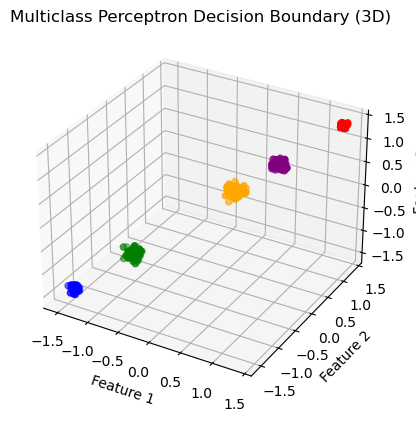

In [234]:
# Define the colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Create a 3D meshgrid to plot the decision boundary
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
z_min, z_max = X_train[:, 2].min() - 1, X_train[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1),
                         np.arange(z_min, z_max, 0.1))

# Plot the decision boundary in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Z = net.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=Y_train, cmap=ListedColormap(colors[:len(np.unique(Y_train))]))
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.title('Multiclass Perceptron Decision Boundary (3D)')
plt.show()


ValueError: shapes (2500,2) and (3,5) not aligned: 2 (dim 1) != 3 (dim 0)

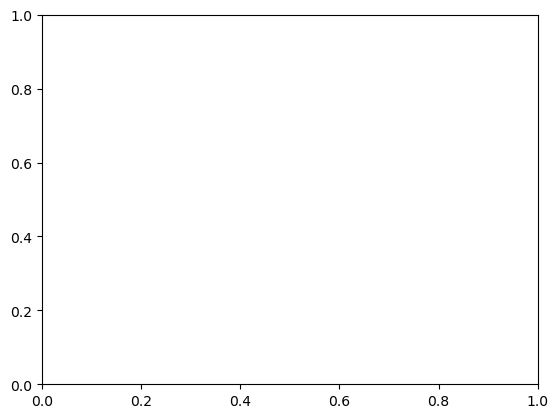

In [238]:
# Define the colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Select two features for visualization (e.g., the first two features)
feature1_index = 0  # Index of the first feature
feature2_index = 1  # Index of the second feature

# Create a meshgrid to plot the decision boundary
x_min, x_max = X_train[:, feature1_index].min() - 1, X_train[:, feature1_index].max() + 1
y_min, y_max = X_train[:, feature2_index].min() - 1, X_train[:, feature2_index].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Plot the decision boundary
fig, ax = plt.subplots()
Z = net.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(colors[:len(np.unique(Y_train))]))

# Plot the training data points
for i, color in zip(range(len(np.unique(Y_train))), colors):
    idx = np.where(Y_train == i)
    ax.scatter(X_train[idx, feature1_index], X_train[idx, feature2_index], c=color, label=i, edgecolor='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Multiclass Perceptron Decision Boundary')
plt.show()


In [239]:
import numpy as np

class KohonenNet:

    def __init__(self, m=3, n=3, lr=1, sigma=1, max_iter=3000, weights=None):
        self.m = m  # Количество классов
        self.n = n  # Количество уровней в сети
        self.shape = (m, n)
        self.initial_lr = lr
        self.lr = lr  # Скорость обучения
        self.sigma = sigma  # Параметр для затухания скорости обучения
        self.max_iter = max_iter

        if weights is None:
            self.weights = np.random.rand(m * n, X_train.shape[1])
        else:
            self.weights = weights

    def _find_bmu(self, x):
        x_stack = np.stack([x] * (self.m * self.n), axis=0)
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        return np.argmin(distance)

    def step(self, x):
        x_stack = np.stack([x] * (self.m * self.n), axis=0)
        bmu_index = self._find_bmu(x)
        self.weights[bmu_index] += self.lr * (x - self.weights[bmu_index])

    def fit(self, X, epochs=1, shuffle=True):
        global_iter_counter = 0
        n_samples = X.shape[0]
        total_iterations = np.minimum(epochs * n_samples, self.max_iter)

        for epoch in range(epochs):
            if global_iter_counter > self.max_iter:
                break

            if shuffle:
                indices = np.random.permutation(n_samples)
            else:
                indices = np.arange(n_samples)

            for idx in indices:
                if global_iter_counter > self.max_iter:
                    break

                input = X[idx]
                self.step(input)
                global_iter_counter += 1
                self.lr = (1 - (global_iter_counter / total_iterations)) * self.initial_lr

        self._n_iter_ = global_iter_counter
        return

    def returnChangedWeights(self):
        return self.weights

    def predict(self, X):
        labels = np.array([self._find_bmu(x) for x in X])
        return labels

# Пример использования
net = KohonenNet(m=3, n=1)
net.fit(X_train, shuffle=True)
predicted_labels = net.predict(X_test)
changed_weights = net.returnChangedWeights()
